## Idea
+ Architecture
    + FFT
    + Mel scale
    + Conv stack - stride 2
    + Put each channel through the stack
    + Fro each note, divide one channel by the other to get l/r data for each note

In [1]:
from onsets_and_frames import *
import torchaudio as ta

In [2]:
from IPython.display import Audio
from fastprogress.fastprogress import master_bar, progress_bar

In [3]:
from fastai import *
from fastai.vision import *

## Default Values

``` Python
SAMPLE_RATE = 16000
HOP_LENGTH = SAMPLE_RATE * 32 // 1000
ONSET_LENGTH = SAMPLE_RATE * 32 // 1000
OFFSET_LENGTH = SAMPLE_RATE * 32 // 1000
HOPS_IN_ONSET = ONSET_LENGTH // HOP_LENGTH
HOPS_IN_OFFSET = OFFSET_LENGTH // HOP_LENGTH
MIN_MIDI = 21
MAX_MIDI = 108
N_MELS = 229
MEL_FMIN = 30
MEL_FMAX = SAMPLE_RATE // 2
WINDOW_LENGTH = 2048
```

In [143]:
ds = MAESTRO(groups=["2006"], sequence_length=100000, device='cpu')

Loading 1 group of MAESTRO at /home/zach/Data/maestro/maestro-v2.0.0


In [144]:
train_len = int(round(0.8*len(ds)))
train_ds, valid_ds = torch.utils.data.random_split(ds, [train_len, len(ds)-train_len])
train_dl, valid_dl = [DataLoader(ds, batch_size=16, shuffle=True, num_workers=6) for ds in [train_ds, valid_ds]]

### Note
Piano starts at MIDI note 21 and goes to 108 so this dataset will only cover that range

In [157]:
plt.rcParams['figure.figsize'] = 9, 16

In [146]:
ex = next(iter(ds))
ex['label'].shape

torch.Size([195, 88])

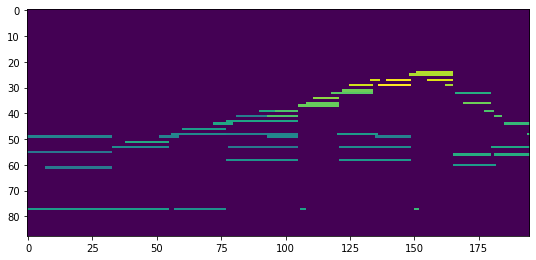

In [147]:
plt.imshow(ex['velocity'].T.flip(0))

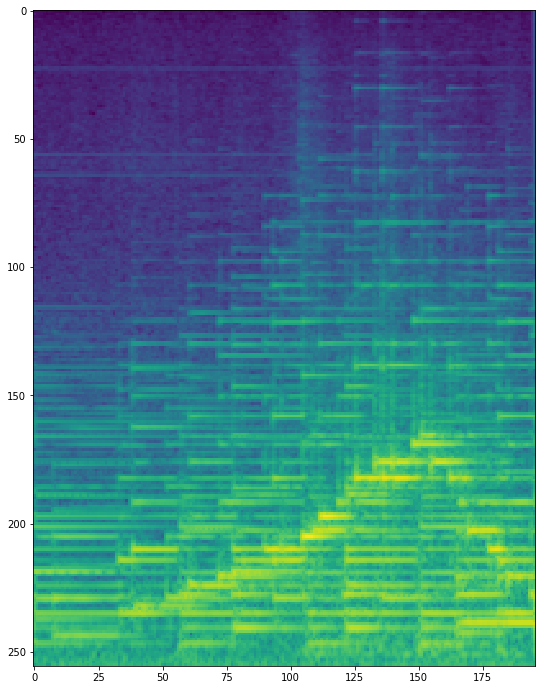

In [148]:
plt.imshow(melspectrogram.cpu()(ex['audio'].unsqueeze(0)).squeeze(0).flip(0))

In [91]:
Audio(ex['audio'].cpu()[:100000], rate=16000)

## Model

In [271]:
def encoder_block(sizes, i, kernel_size, padding):
    return nn.Sequential(
        nn.Conv1d(sizes[i-1][1], sizes[i][1], kernel_size, 2, padding, dilation=1),
        #nn.BatchNorm1d(sizes[i][1]),
        nn.Tanh(),
    )

In [272]:
class Audio2Midi(nn.Module):
    def __init__(self, kernel_size):
        super(Audio2Midi, self).__init__()
        sizes = [(256, 64), (128, 128), (64, 256)]
        self.sizes = sizes
        padding = kernel_size // 2
        self.input = nn.Conv1d(1, sizes[0][1], kernel_size, 1, padding)
        
        self.encoder = nn.Sequential(
            *[encoder_block(sizes, i, kernel_size, padding) for i in range(1, len(sizes))]
        )
        
        self.linear = nn.Linear(128*128, 88)
        self.rnn = nn.GRU(128, 88)
        self.rnn_state = None
        
    def forward(self, x):
        x = self.input(x)
        #print(x.shape)
        for l in self.encoder:
            x = l(x)
            #print(x.shape)
        x = x.flatten(1)
        #print(x.shape)
        x = self.linear(x)
        #x,self.rnn_state = self.rnn(x.unsqueeze(0))
        #print(x.shape)
        return F.relu(x).squeeze(0)
    

In [273]:
class Baseline(nn.Module):
    def __init__(self):
        super(Baseline, self).__init__()
        self.l1 = nn.Linear(256, 512)
        self.l2 = nn.Linear(512, 88)
        
    def forward(self, x):
        x = self.l1(x)
        x = F.tanh(x)
        x = self.l2(x)
        x = F.tanh(x)
        return F.sigmoid(x).squeeze()

In [274]:
testnn = Audio2Midi(kernel_size=9)

ex = next(iter(train_dl))
ip_ex = melspectrogram.cpu()(ex['audio']).squeeze(0)
ip_ex.shape

test_output = testnn.forward(ip_ex[:,:,3].unsqueeze(1))
test_output.shape

torch.Size([16, 88])

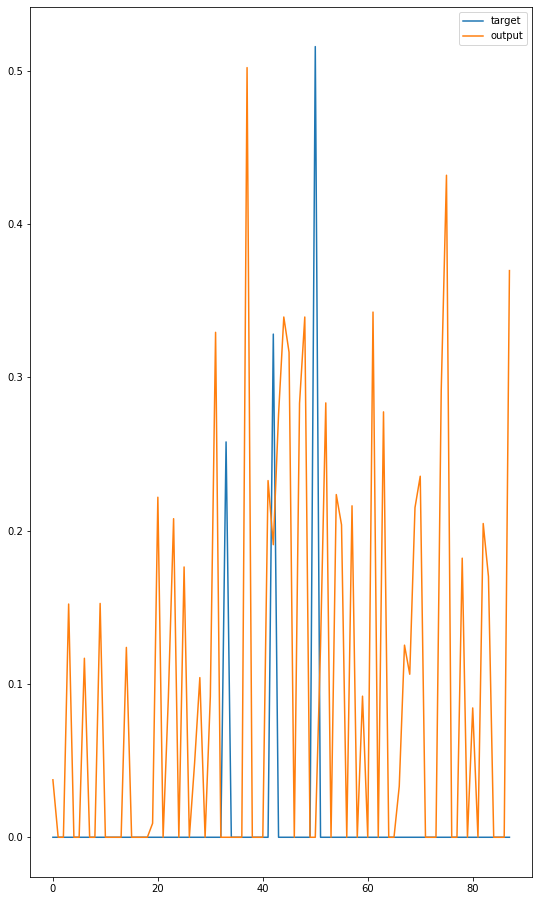

KeyboardInterrupt: 

In [281]:
n_epochs = 30

train_ls = []
valid_ls = []

m = Audio2Midi(kernel_size=9)
m = m.cuda()
optim = torch.optim.Adam(params=m.parameters(), lr=1e-5)
critereon = nn.MSELoss()

mb = master_bar(range(n_epochs))
mb.names = ['train', 'valid']
for e in mb:
    m.train()
    tl = 0
    for idx,it in enumerate(progress_bar(train_dl, parent=mb)):
        audio, target = melspectrogram(it["audio"]), it["velocity"]
        for seg in range(target.shape[2]):
            out = m(audio.cuda()[:,:,seg].unsqueeze(1))
            l = critereon(out, target.cuda()[:,seg,:])
            l.backward()
            optim.step()
            tl += l.detach().cpu().item()
            m.zero_grad()
            
            
            if seg == 0 and idx == 0 and e%5==0:
                plt.plot(target[1,1,:], label="target")
                plt.plot(out[1,:].detach().cpu(), label="output")
                plt.legend()
                plt.show()
    train_ls.append(tl)
    print(tl)
    with torch.no_grad():
        vl = 0
        for it in progress_bar(valid_dl, parent=mb):
            audio, target = melspectrogram(it["audio"]), it["velocity"]
            for seg in range(target.shape[2]):
                out = m(audio.cuda()[:,:,seg].unsqueeze(1))
                l = critereon(out, target.cuda()[:,seg,:])
                vl += l.detach().cpu().item()
        valid_ls.append(vl)
    mb.update_graph([[range(e+1), train_ls], [range(e+1), valid_ls]])

In [ ]:
from MelodyMatrix import *

In [ ]:
lvectest = torch.randn(88, 1)
rvectest = torch.randn(88, 1)

In [22]:
def make_frame(l_vec, r_vec, genre, thresh):
    """
    Creates a frame for visualization stack out of left and right machine learning outputs
    Arguments:
        l_vec: velocity vector for left channel
        r_vec: velocity vector for right channel
        genre: genre to pass through to frame
        thresh: velocity value under which to ignore note
    """
    notes = []
    
    pans = r_vec / l_vec
    pans /= max(pans)
    pans *= 127
    velocities = [max(l_vec[i,0], r_vec[i,0]) for i in range(l_vec.shape[0])]
    for pitch,vel,pan in zip(range(l_vec.shape[0]), velocities, pans):
        if vel > thresh:
            notes.append(Note(pitch, vel, pans[pitch]))
        
    print()
    frame = Frame(notes, genre)
    return frame

In [22]:
f = make_frame(lvectest, rvectest, Genre('Pop'), 1)

In [23]:
len(f.notes)

19